In [10]:
import torch
from diffusion.models.unet import UNet
from diffusion.diffusion.forward import ForwardDiffusion
import matplotlib.pyplot as plt
from diffusion.sampling import DDIMSampler
from tqdm import tqdm

In [11]:
@torch.no_grad()
def p_sample(model, x, t, t_index, labels, diffusion_instance):
    betas_t = diffusion_instance.betas[t_index].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(
        1.0 - diffusion_instance.alphas_cumprod[t_index]
    ).view(-1, 1, 1, 1)
    sqrt_recip_alphas_t = torch.sqrt(1.0 / diffusion_instance.alphas[t_index]).view(
        -1, 1, 1, 1
    )

    pred_noise = model(x, t, labels)

    mean = sqrt_recip_alphas_t * (
        x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t
    )
    if t_index == 0:
        return mean
    else:
        sigma_t = torch.sqrt(betas_t)
        noise = torch.randn_like(x)
        return mean + sigma_t * noise

In [14]:
def generate_digit(
    digit, num_samples=1, use_ddim=True, steps=50, visualize_steps=False
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = UNet(time_emb_dim=128, class_emb_dim=64, num_classes=10).to(device)
    model.load_state_dict(torch.load("../checkpoints/unet_class_conditional.pth"))
    model.eval()

    labels = torch.full((num_samples,), digit, device=device)

    global diffusion
    diffusion = ForwardDiffusion(timesteps=1000)

    generated_images = []

    if use_ddim:
        sampler = DDIMSampler(model, diffusion, eta=0.0)
        x = torch.randn((num_samples, 1, 32, 32), device=device)
        timesteps = torch.linspace(diffusion.timesteps - 1, 0, steps, dtype=torch.long)

        for i, t in enumerate(tqdm(timesteps)):
            t_tensor = torch.full((x.shape[0],), t, device=x.device)
            pred_noise = model(x, t_tensor, labels)

            alpha = diffusion.alphas_cumprod[t]
            alpha_prev_idx = t - 1 if t > 0 else 0
            alpha_prev = (
                diffusion.alphas_cumprod[alpha_prev_idx]
                if t > 0
                else torch.tensor(1.0, device=device)
            )

            sigma = sampler.eta * torch.sqrt(
                (1 - alpha_prev) / (1 - alpha) * (1 - alpha / alpha_prev)
            )

            x0_pred = (x - torch.sqrt(1 - alpha) * pred_noise) / torch.sqrt(alpha)
            x = (
                torch.sqrt(alpha_prev) * x0_pred
                + torch.sqrt(1 - alpha_prev - sigma**2) * pred_noise
                + sigma * torch.randn_like(x)
            )

            if visualize_steps and (i % (steps // 5) == 0 or i == len(timesteps) - 1):
                # Detach the tensor before converting to numpy
                generated_images.append(
                    (
                        x[0, 0].detach().cpu().numpy(),
                        f"DDIM Step {diffusion.timesteps - t.item()}",
                    )
                )

    else:
        x = torch.randn((num_samples, 1, 32, 32), device=device)
        for i, t_index in enumerate(tqdm(reversed(range(diffusion.timesteps)))):
            t_tensor = torch.full((num_samples,), t_index, device=device)
            x = p_sample(model, x, t_tensor, t_index, labels, diffusion)

            if visualize_steps and (
                i % (diffusion.timesteps // 5) == 0 or i == diffusion.timesteps - 1
            ):
                # Detach the tensor before converting to numpy
                generated_images.append(
                    (x[0, 0].detach().cpu().numpy(), f"DDPM Step {t_index}")
                )

    if visualize_steps:
        plt.figure(figsize=(len(generated_images) * 3, 4))
        for i, (img, title) in enumerate(generated_images):
            plt.subplot(1, len(generated_images), i + 1)
            plt.imshow(img, cmap="gray")
            plt.title(title)
            plt.axis("off")
        plt.suptitle(f"Generated Digit: {digit} - Intermediate Steps")
        plt.tight_layout()
        plt.show()

    plt.imshow(x[0, 0].detach().cpu().numpy(), cmap="gray")
    plt.title(
        f"Generated Digit: {digit} (DDIM, {steps} steps)"
        if use_ddim
        else f"Digit: {digit} (DDPM)"
    )
    plt.axis("off")
    plt.show()

100%|██████████| 300/300 [00:06<00:00, 43.99it/s]


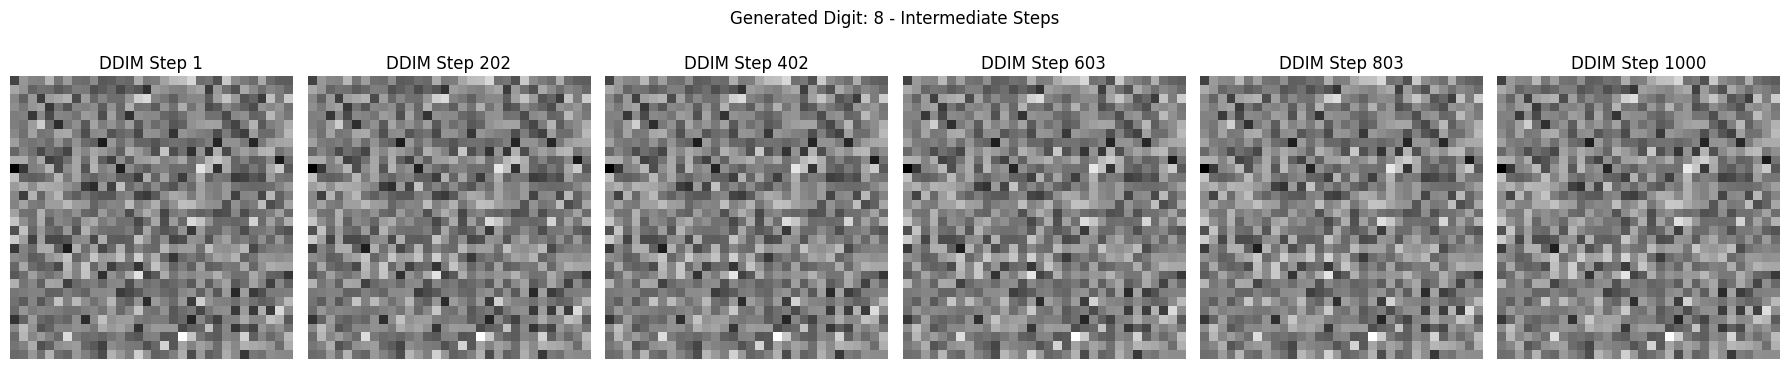

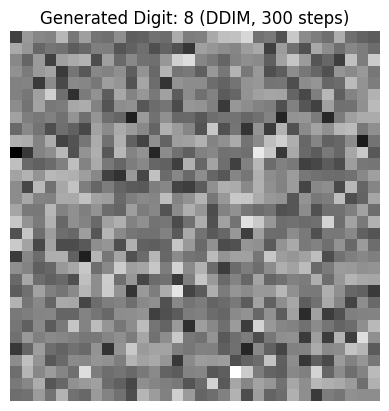

In [15]:
diffusion = ForwardDiffusion(timesteps=1000)
generate_digit(digit=8, use_ddim=True, steps=300, visualize_steps=True)
